<font color="FF3B3B"><h1 align="left">Proyecto de aprendizaje profundo</h1></font>
<font color="#6E6E6E"><h2 align="left">Modelo lineal simple</h2></font>

##### David Alejandro Pedroza De Jesús
##### Joel Ezequiel Vicente Alonso

Cargamos las librerias para la realización del proyecto

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np
import pandas as pd
import cv2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import os
import kagglehub
from shutil import move
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay

# Descarga, carga y limpieza de datos.

En este paso cargamos los datos como lo hicimos en el analisis exploratorio

In [ ]:
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

Using Colab cache for faster access to the 'cards-image-datasetclassification' dataset.


Cargamos las rutas que vamos a utilizar, las limpiaremos y adaptaremos.

In [ ]:
datos = pd.read_csv(r"cards-image-datasetclassification/cards.csv")
datos.head()

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


Quitaremos la ruta que no funciona y creamos un nuevo df con las rutas adaptadas y funcionales.

In [ ]:
rutas_adaptadas = ["cards-image-datasetclassification/" +  ruta for ruta in datos["filepaths"]]
im_buenas = []
im_malas = []
for ru in rutas_adaptadas:
    im = cv2.imread(ru)
    if  im is not None:
        im_buenas.append(ru)
    else:
        im_malas.append(ru)
print(f"Lecturas correctas: {len(im_buenas)}")
print(f"Lecturas incorrectas: {len(im_malas)}")

df_limpio = datos[np.array(rutas_adaptadas) != np.array(im_malas)]
df_limpio["rutas_adap"] = im_buenas

Lecturas correctas: 8154
Lecturas incorrectas: 1


/tmp/ipython-input-10419/4150467203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio["rutas_adap"] = im_buenas


# Extración de caracteristicas.

Para esta tarea podría emplearse una red neuronal para obtener un vector de características (embedding). Sin embargo, en este notebook evitaremos este tipo de aproximaciones, ya que no constituyen el objetivo principal del trabajo.

En su lugar, utilizaremos HOG (Histogram of Oriented Gradients), un descriptor clásico de visión por computador basado en la distribución de gradientes de intensidad. Este método permite capturar información estructural y de contorno, representando eficazmente las formas presentes en la imagen.

Este enfoque resulta especialmente adecuado en el caso de cartas, ya que contienen símbolos y figuras con geometrías bien definidas y altamente distintivas. HOG es particularmente eficaz para modelar este tipo de patrones.

Una limitación del descriptor es que opera sobre imágenes en escala de grises, por lo que no aprovecha directamente la información cromática. No obstante, dado que la discriminación entre cartas depende en gran medida de la forma y estructura de los símbolos, es razonable esperar que esta representación sea suficiente para obtener un buen desempeño en la clasificación.

Para implentar esto crearemos una función en python que pueda calcular el vector de cada imagen.

In [ ]:
def features_extract(path):
  img = cv2.imread(path)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  features = hog(img_gray,
                 pixels_per_cell=(8,8),
                 cells_per_block=(2,2),
                 feature_vector=True)
  return features

Ahora obtenemos los vectores de caracteristicas de cada una de las imagenes.

In [ ]:
rutas_train = df_limpio[df_limpio["data set"] == "train"].rutas_adap
rutas_test = df_limpio[df_limpio["data set"] == "test"].rutas_adap
rutas_val = df_limpio[df_limpio["data set"] == "valid"].rutas_adap

X_train = np.array([features_extract(p) for p in rutas_train])
X_test = np.array([features_extract(p) for p in rutas_test])
X_val = np.array([features_extract(p) for p in rutas_val])

In [ ]:
y_train = df_limpio[df_limpio["data set"] == "train"]["labels"]
y_test = df_limpio[df_limpio["data set"] == "test"]["labels"]
y_val = df_limpio[df_limpio["data set"] == "valid"]["labels"]

# Preparación de los datos

## Normalización de los datos

Siempre es necesario normalizar nuestros datos a la hora de entrenar modelo, en nuestro caso usamos `StandardScaler`.

In [ ]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
X_val_norm = scaler.transform(X_val)

## Codificación de las etiquetas

Usaremos label encoder para que podamos utilizar la regresión logistica, para esta tarea.

In [ ]:
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train.values.reshape(-1,1))
y_test_enc = encoder.transform(y_test.values.reshape(-1,1))
y_val_enc = encoder.transform(y_val.values.reshape(-1,1))

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


# Entrenamiento y metricas.

La regresión logistica y sklearnd en general no funciona como keras, por lo que si queremos tener la curva de validación y entrenamiento debemos de hacerlo a mano.

In [ ]:
model = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    multi_class="multinomial",
    max_iter=2000
)

In [ ]:

model.fit(X_train_norm, y_train_enc)

y_train_prob = model.predict_proba(X_train_norm)
y_val_prob = model.predict_proba(X_val_norm)
y_test_prob = model.predict_proba(X_test_norm)

train_loss = log_loss(y_train_enc, y_train_prob)
val_loss = log_loss(y_val_enc, y_val_prob)
test_loss = log_loss(y_test_enc, y_test_prob)

score = model.score(X_val_norm, y_val_enc)

print(f"Score: {score}")
print(f"Train loss: {train_loss}")
print(f"Val loss: {val_loss}")
print(f"test loss: {test_loss}")
print(f"Accuracy: {accuracy_score(y_test_enc, model.predict(X_test_norm))}")


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Score: 0.7132075471698113
Train loss: 0.0009520553251317251
Val loss: 1.52651310845312
test loss: 1.52651310845312
Accuracy: 0.6943396226415094


## Matriz de confusión

Aunque no se pida al ser un problema de clasificación es importante mostrar su matriz de confución.

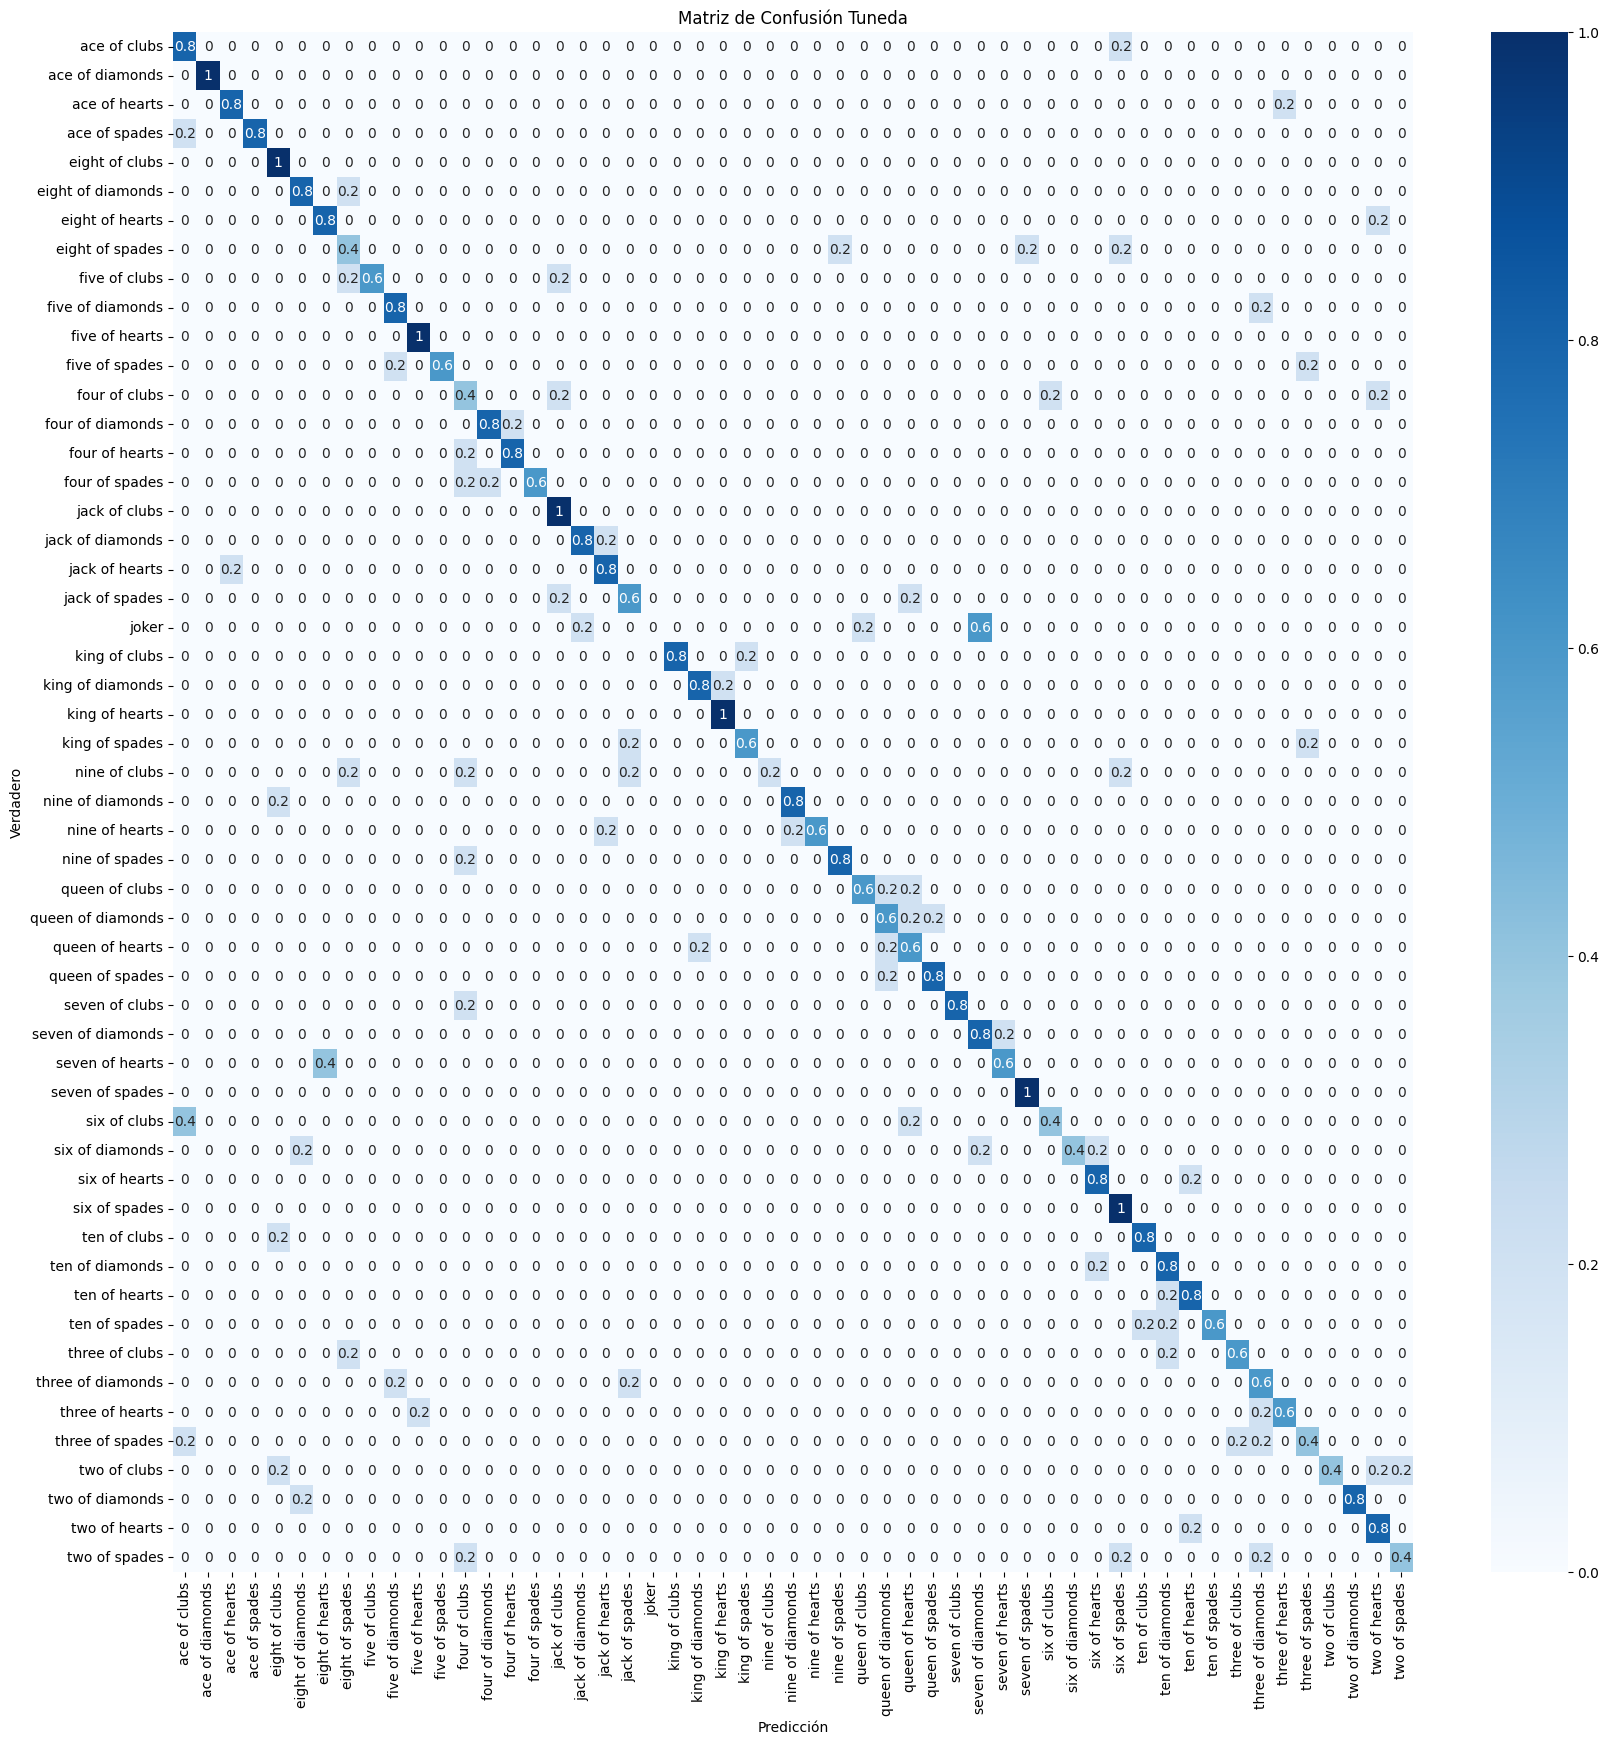

In [ ]:
class_names = encoder.classes_


cm = confusion_matrix(y_test_enc, model.predict(X_test_norm), normalize="true")


plt.figure(figsize=(20, 20))
sns.heatmap(cm,
            annot=True, cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True)

plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión Tuneda')
plt.yticks(rotation=0)
plt.show()

# Conclusión

Parece ser que el modelo de regresión logistica es una buena opción para tratar el problema, aunque como hemos visto en otros modelo aplicados a este problema tiene mucho margen de mejora.